## Analysis of EVI Trend Break Magnitudes with XGBRegressor

Peter R., 2023-08-07

### Intro
There are several way to carry our Extreme Gradient Boosting (XGB). You could use R or Python.  There are several R packages to do XGB such as "dismo" and "xgboosting". In Python there are several ways as well. You can do XGB with the sklearn framework and within this framework you can use train(), XGBClassifier(), XGBRegressor() etc.  Here I use XGBRegression() to analyze forest EVI breaks (both negative & positive breaks) together.

Here I try to answer the question: What factors predict EVI (negative and positive) Trend Break magnitude?

Note that driver data have been assigned here by using spatio-temporal matches between breaks and remote sensing derived disturbance data. So far, I only have data for three drivers: fire, harvest, & insects.  The driver data are mainly nulls as I was not able to match most of the EVI breaks with disturbance data.  An important missing driver is likely tree windthrow.

#### File and folder path settings

In [1]:
# Import the os module
import os

# Get the current working directory
cwd = os.getcwd()

print(cwd)

C:\Users\Peter R\github\forc_trends\models\xgboost


#### Load and explore the data

In [157]:
import pandas as pd
#from pandas import read_csv
from numpy import nan

df1 = pd.read_csv(r'.\data\forest_evi_breaks_sam1.csv', skipinitialspace=True)
df1.head()


,year,magnitude,fire,harvest,insects,age,deciduous,conifers,protected,elevation,precipitation,temperature,precipitation_lag,temperature_lag,longitude,latitude
0,2006,-506,NaN,NaN,NaN,63.35,73.68,26.17,0,359,1009.0,5.50,848,4.09,-6023413,5088216
1,2013,-634,NaN,NaN,NaN,74.98,96.72,2.96,0,437,1168.0,3.50,980,5.22,-6072987,5126208
2,2009,-1172,NaN,NaN,NaN,73.82,63.79,36.21,0,334,953.0,3.91,1051,4.66,-6076694,5132231
3,2015,-1459,NaN,NaN,NaN,89.00,85.54,14.34,0,378,837.0,4.06,1076,4.12,-6067891,5124354
4,2006,-598,NaN,NaN,NaN,53.22,52.95,46.87,0,310,1009.0,5.11,857,3.70,-6037312,5115320


In [63]:
# note: in this test data set, protected has a single value. Hence, get_dummies does not work as expected
df2 = pd.get_dummies(df1, columns=['protected'], dtype=float)
#df2 = pd.get_dummies(df1, columns=['year', 'protected'], dtype=float)

df2.head()


,year,magnitude,fire,harvest,insects,age,deciduous,conifers,elevation,precipitation,temperature,precipitation_lag,temperature_lag,longitude,latitude,protected_0,protected_1
0,2006,-506,NaN,NaN,NaN,63.35,73.68,26.17,359,1009.0,5.50,848,4.09,-6023413,5088216,1.0,0.0
1,2013,-634,NaN,NaN,NaN,74.98,96.72,2.96,437,1168.0,3.50,980,5.22,-6072987,5126208,1.0,0.0
2,2009,-1172,NaN,NaN,NaN,73.82,63.79,36.21,334,953.0,3.91,1051,4.66,-6076694,5132231,1.0,0.0
3,2015,-1459,NaN,NaN,NaN,89.00,85.54,14.34,378,837.0,4.06,1076,4.12,-6067891,5124354,1.0,0.0
4,2006,-598,NaN,NaN,NaN,53.22,52.95,46.87,310,1009.0,5.11,857,3.70,-6037312,5115320,1.0,0.0


In [167]:
#print(df2.describe)

# Remove records where precipitation is null
df2= df2[df2['precipitation'].notna()]
print(df2.describe)

<bound method NDFrame.describe of      year  magnitude  fire  harvest  insects    age  deciduous  conifers  \
0    2006       -506   NaN      NaN      NaN  63.35      73.68     26.17   
1    2013       -634   NaN      NaN      NaN  74.98      96.72      2.96   
2    2009      -1172   NaN      NaN      NaN  73.82      63.79     36.21   
3    2015      -1459   NaN      NaN      NaN  89.00      85.54     14.34   
4    2006       -598   NaN      NaN      NaN  53.22      52.95     46.87   
..    ...        ...   ...      ...      ...    ...        ...       ...   
790  2016      -1074   NaN      1.0      NaN  21.76      64.63     35.38   
791  2013       -594   NaN      NaN      NaN  76.84      76.63     23.32   
792  2010       -753   NaN      NaN      NaN  78.52      67.96     31.95   
793  2009        432   NaN      NaN      NaN  54.88      24.90     73.66   
794  2011        647   NaN      NaN      NaN  71.72      60.33     39.13   

     elevation  precipitation  temperature  precipita

In [80]:
#df2.tail()

#pd.to_numeric(df2)

# check data types
print(df2.dtypes)


year                   int64
magnitude              int64
fire                 float64
harvest              float64
insects              float64
age                  float64
deciduous            float64
conifers             float64
elevation              int64
precipitation        float64
temperature          float64
precipitation_lag      int64
temperature_lag      float64
longitude              int64
latitude               int64
protected_0          float64
protected_1          float64
dtype: object


In [168]:
# split data into input and output columns
#from numpy import absolute

X1 = df2.iloc[:,5:18]
X1.drop(X1.columns[[2]], axis=1,inplace=True) # conifers & deciduous are highly negatively correlated. I drop conifers
print(X1.head())

#df[list(df.columns[:2]) + [7]]

print(X1.describe)


     age  deciduous  elevation  precipitation  temperature  precipitation_lag  \
0  63.35      73.68        359         1009.0         5.50                848   
1  74.98      96.72        437         1168.0         3.50                980   
2  73.82      63.79        334          953.0         3.91               1051   
3  89.00      85.54        378          837.0         4.06               1076   
4  53.22      52.95        310         1009.0         5.11                857   

   temperature_lag  longitude  latitude  protected_0  protected_1  
0             4.09   -6023413   5088216          1.0          0.0  
1             5.22   -6072987   5126208          1.0          0.0  
2             4.66   -6076694   5132231          1.0          0.0  
3             4.12   -6067891   5124354          1.0          0.0  
4             3.70   -6037312   5115320          1.0          0.0  
<bound method NDFrame.describe of        age  deciduous  elevation  precipitation  temperature  \
0    63

In [159]:
y1 = df2.iloc[:,1]
print("Response/label data")
print(y1.head())

#print("Response/label data, Absolute value of Negative break magnitude")
#y2 = absolute(y1)
#print(y2.head())

#X, y = df2[:, :-1], df2[:, -1]
#X.head()

Response/label data
0    -506
1    -634
2   -1172
3   -1459
4    -598
Name: magnitude, dtype: int64


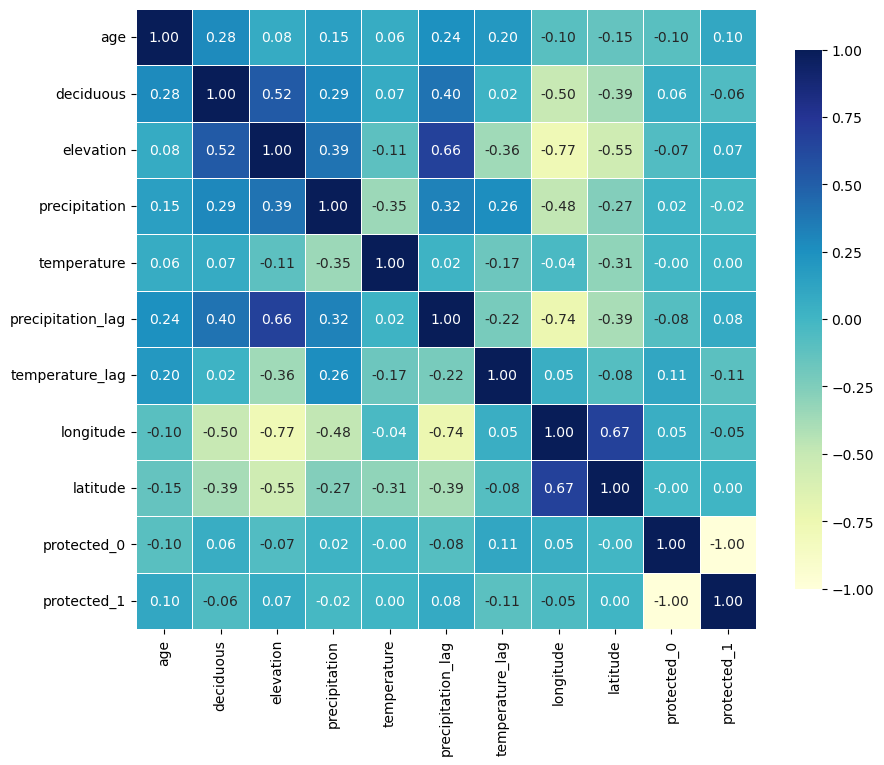

In [161]:
import seaborn as sns

def correlation_heatmap(X1):
    correlations = X1.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )

    #plt.show();

features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]

correlation_heatmap(X1[features_names1])
# sorted_idx = xgb.feature_importances_.argsort()

plt.savefig('correlation2.png',  dpi=300, bbox_inches='tight')


plt.show()

#### Set up & run model

Here the model evaluation metric is mean absoulte error. Other metrics are available for regression.


In [162]:
# evaluate an xgboost regression model on the housing dataset
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

print("XGB version:", xgb.__version__)

# split data into input and output columns
#X, y = df2[:, :-1], df2[:, -1]

seed = 7 # random seed to help with replication
testsize1 = 0.2 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=testsize1, random_state=seed)

# set custom parameters rather than use defaults
# 'reg:linear', reg:squarederror
param = {
    'max_depth': 4,
    'eta':0.3,
    'objective': 'reg:squarederror',
   
}

epochs = 10


# define model
model_m2a = XGBRegressor(set_params=param)

# n_estimators is the number of trees
print(model_m2a)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
scores = cross_val_score(model_m2a, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) ) # 289.996 (52.529), Mean MAE: 288.345 (51.031); Mean MAE: 561.678 (63.102)

XGB version: 1.7.6
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Mean MAE: 560.989 (63.347)


In [163]:
# evaluate model with mean square error
scores2 = cross_val_score(model_m2a, x1_train, y1_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores2 = absolute(scores)
print('Mean MSE: %.3f (%.3f)' % (scores2.mean(), scores2.std()) ) # Mean MSE: 289.996 (52.529); 288.345 (51.031); Mean MSE: 577.740 (58.160), Mean MSE: 561.678 (63.102)


Mean MSE: 560.989 (63.347)


In [164]:
#import statistics

# evaluate model with variance explained
scores3 = cross_val_score(model_m2a, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365); 0.102 (0.466)

Mean Var. Explained: 0.151 (0.158)


#### Fine tunning parameters
Fine tune parameters to find a better model (potentially). 

In [165]:
# Fine tune parameters using GridSearchCV (for exhaustive searches) or RandomizedSearchCV (faster)

# Take 1
from sklearn.model_selection import RandomizedSearchCV

#search space
params_xgboost = {
 #"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "learning_rate"    : [ 0.05, 0.10, 0.15],
 #"max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "max_depth"        : [ 3, 4, 5,],
 #"min_child_weight" : [ 1, 3, 5, 7 ],
 #"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "gamma"            : [ 0.0, 0.1, 0.25],
 #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
 #'n_estimators'     : [5, 10, 15, 20, 25, 30, 35],
 'objective': ['reg:squarederror']
}

model_m2b = XGBRegressor()

random_search = RandomizedSearchCV(estimator = model_m2b, 
                      param_distributions = params_xgboost, 
                      n_iter = 100, 
                      cv = 5, 
                      verbose=1, 
                      random_state=42,
                      scoring = 'neg_mean_squared_error', 
                      n_jobs = -1)

#params glare proba
random_search.fit(x1_train, y1_train), 

random_search.best_estimator_



C:\Users\Peter R\.conda\envs\xgboost1\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 27 candidates, totalling 135 fits


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [169]:
# Optimal model according to random search above

model_m2c = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None)


#print(model_m2c)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
scores = cross_val_score(model_m2c, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )
# with fire, harv, ins nulls: Mean MAE: 566.434 (51.825)
# Mean MAE: 556.860 (56.363)


Mean MAE: 555.873 (55.005)


In [170]:
# evaluate model with variance explained
scores3 = cross_val_score(model_m2c, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365); 0.145 (0.423)
# nulls: Mean Var. Explained: 0.206 (0.116)
# Mean Var. Explained: 0.192 (0.121)


Mean Var. Explained: 0.194 (0.125)


In [172]:
# Take 2
# Given that learning_rate and max_depth were at the their upper limit I ran RandomizedSearchCV with expanded values
from sklearn.model_selection import RandomizedSearchCV

#search space
params_xgboost = {
 #"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "learning_rate"    : [ 0.01, 0.03, 0.05],
 #"max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "max_depth"        : [5, 6,7],
 #"min_child_weight" : [ 1, 3, 5, 7 ],
 #"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 #"gamma"            : [ 0.0, 0.25 , 1.0 ], # 0.25 was chosen
 "gamma"            : [ 0.01, 0.05, 0.1], # 0.0 was chosen
 #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
 #'n_estimators'     : [5, 10, 15, 20, 25, 30, 35],
 'objective': ['reg:squarederror']
}

model_m2d = XGBRegressor()

random_search = RandomizedSearchCV(estimator = model_m2d, 
                      param_distributions = params_xgboost, 
                      n_iter = 100, 
                      cv = 5, 
                      verbose=1, 
                      random_state=42,
                      scoring = 'neg_mean_squared_error', 
                      n_jobs = -1)

#params glare proba
random_search.fit(x1_train, y1_train)

random_search.best_estimator_

C:\Users\Peter R\.conda\envs\xgboost1\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.


Fitting 5 folds for each of 27 candidates, totalling 135 fits


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [173]:
# Optimal model according to random search
model_m2e = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
scores = cross_val_score(model_m2e, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) ) #Mean MAE: 555.691 (50.281)
#Mean MAE: 566.044 (56.495)

Mean MAE: 564.919 (55.528)


In [174]:
# evaluate model with variance explained
scores3 = cross_val_score(model_m2e, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365)
# Variance explained is more than model_m2c. Model_m2d seems better.
# nulls out: Mean Var. Explained: 0.218 (0.121), model_m2c explain more
# Mean Var. Explained: 0.186 (0.114)


Mean Var. Explained: 0.187 (0.118)


#### Evaluation

In [175]:
from matplotlib import pyplot

eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
model_m2e.fit(x1_train, y1_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model_m2e.predict(x1_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
#accuracy = accuracy_score(y1_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model_m2e.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)


[0]	validation_0-error:-601.94444	validation_0-logloss:-23983.01291	validation_1-error:-393.79114	validation_1-logloss:-15704.83203
[1]	validation_0-error:-602.06349	validation_0-logloss:-24386.08684	validation_1-error:-398.25316	validation_1-logloss:-16103.71267
[2]	validation_0-error:-621.23968	validation_0-logloss:-25377.42052	validation_1-error:-381.81013	validation_1-logloss:-15626.58386
[3]	validation_0-error:-625.81111	validation_0-logloss:-25734.95705	validation_1-error:-394.25949	validation_1-logloss:-16201.04979
[4]	validation_0-error:-639.02222	validation_0-logloss:-26319.33543	validation_1-error:-374.38608	validation_1-logloss:-15494.61362
[5]	validation_0-error:-627.18730	validation_0-logloss:-26029.69895	validation_1-error:-385.45570	validation_1-logloss:-15972.62224
[6]	validation_0-error:-625.47937	validation_0-logloss:-26041.59199	validation_1-error:-371.62658	validation_1-logloss:-15482.60726
[7]	validation_0-error:-623.27460	validation_0-logloss:-26035.43177	validati

C:\Users\Peter R\.conda\envs\xgboost1\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.


[25]	validation_0-error:-647.25238	validation_0-logloss:-27648.80658	validation_1-error:-388.48101	validation_1-logloss:-16495.50326
[26]	validation_0-error:-647.25238	validation_0-logloss:-27660.97781	validation_1-error:-388.48101	validation_1-logloss:-16535.59960
[27]	validation_0-error:-647.25238	validation_0-logloss:-27682.33117	validation_1-error:-388.48101	validation_1-logloss:-16526.76096
[28]	validation_0-error:-654.76984	validation_0-logloss:-27981.28464	validation_1-error:-388.48101	validation_1-logloss:-16560.67021
[29]	validation_0-error:-645.92381	validation_0-logloss:-27717.78427	validation_1-error:-395.53797	validation_1-logloss:-16841.93203
[30]	validation_0-error:-659.04603	validation_0-logloss:-28224.23203	validation_1-error:-395.53797	validation_1-logloss:-16853.34458
[31]	validation_0-error:-654.56349	validation_0-logloss:-28040.55399	validation_1-error:-395.53797	validation_1-logloss:-16725.81507
[32]	validation_0-error:-655.13175	validation_0-logloss:-28070.16224	

[87]	validation_0-error:-717.20794	validation_0-logloss:-31002.27672	validation_1-error:-400.13291	validation_1-logloss:-17271.42582
[88]	validation_0-error:-717.20794	validation_0-logloss:-31008.45711	validation_1-error:-400.13291	validation_1-logloss:-17277.97451
[89]	validation_0-error:-717.20794	validation_0-logloss:-31011.36030	validation_1-error:-400.13291	validation_1-logloss:-17276.60172
[90]	validation_0-error:-718.95556	validation_0-logloss:-31082.55046	validation_1-error:-400.13291	validation_1-logloss:-17278.70748
[91]	validation_0-error:-718.95556	validation_0-logloss:-31085.26996	validation_1-error:-400.13291	validation_1-logloss:-17275.45591
[92]	validation_0-error:-717.79206	validation_0-logloss:-31048.36264	validation_1-error:-400.13291	validation_1-logloss:-17275.27938
[93]	validation_0-error:-717.79206	validation_0-logloss:-31052.15102	validation_1-error:-388.15190	validation_1-logloss:-16829.91348
[94]	validation_0-error:-720.29841	validation_0-logloss:-31108.02743	

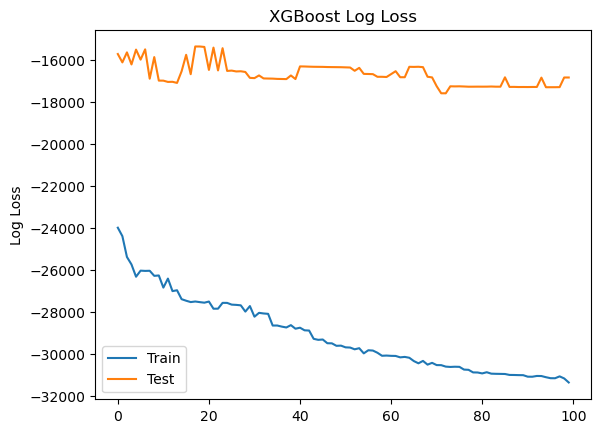

In [176]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

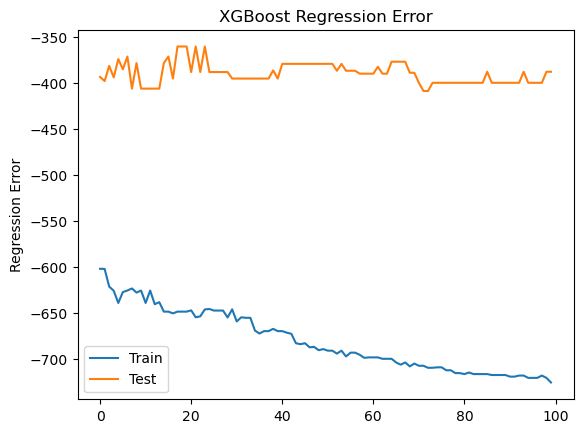

In [177]:
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Regression Error')
pyplot.title('XGBoost Regression Error')
pyplot.show()

In [178]:
# implemenmting early stopping to avoid overfitting

model_m2e.fit(x1_train, y1_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True) #peaks at run 15


[0]	validation_0-logloss:-23983.01291	validation_1-logloss:-15704.83203
[1]	validation_0-logloss:-24386.08684	validation_1-logloss:-16103.71267
[2]	validation_0-logloss:-25377.42052	validation_1-logloss:-15626.58386
[3]	validation_0-logloss:-25734.95705	validation_1-logloss:-16201.04979
[4]	validation_0-logloss:-26319.33543	validation_1-logloss:-15494.61362
[5]	validation_0-logloss:-26029.69895	validation_1-logloss:-15972.62224
[6]	validation_0-logloss:-26041.59199	validation_1-logloss:-15482.60726
[7]	validation_0-logloss:-26035.43177	validation_1-logloss:-16881.88867
[8]	validation_0-logloss:-26277.62706	validation_1-logloss:-15850.88299
[9]	validation_0-logloss:-26258.87842	validation_1-logloss:-16972.23181
[10]	validation_0-logloss:-26837.27434	validation_1-logloss:-16974.15813
[11]	validation_0-logloss:-26407.80039	validation_1-logloss:-17034.65275
[12]	validation_0-logloss:-27004.70755	validation_1-logloss:-17028.63399
[13]	validation_0-logloss:-26963.95844	validation_1-logloss:-

C:\Users\Peter R\.conda\envs\xgboost1\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Predictions
Now let's see how well the models can predict when given new data.

In [179]:
# fit a final xgboost model on the housing dataset and make a prediction
from numpy import asarray
from numpy import nan

# define model
#model = XGBRegressor()

# fit model
model_m2e.fit(X1, y1, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False) # early_stopping_rounds=10

# define new data
#row = [63.0, 16.5, 68.8, 0, 360, 1008, 1.0, 1.0, 0.0, 0.0, ]
#row =[1,nan,nan,73.82,63.79,36.21,334,953.0,3.91,1151,5.66,-6076694,5132231,1.0,0.0]
#row =[nan,1,nan,73.82,63.79,36.21,334,953.0,3.91,1151,5.66,-6076694,5132231,1.0,0.0]
#row =[nan,nan,1,73.82,63.79,36.21,334,953.0,3.91,1151,5.66,-6076694,5132231,1.0,0.0]
#row =[73.82,63.79,36.21,334,953.0,3.91,1151,5.66,-6076694,5132231,1.0,0.0]
row =[73.82,63.79,334,953.0,3.91,1151,5.66,-6076694,5132231,1.0,0.0]
new_data = asarray([row])

# make a prediction
yhat = model_m2e.predict(new_data)

# summarize prediction
print('Predicted: %.3f' % yhat) # Predicted: 532.376, 574.485, Predicted: 576.899, Fire Predicted: -316.809; Harvest Predicted: -370.450


Predicted: -520.768


In [180]:
# Predict using test data set

from sklearn.metrics import mean_squared_error

model_m2e.fit(x1_train, y1_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False)
#model_m2e.fit(x1_train, y1_train, early_stopping_rounds=10, eval_metric="error", eval_set=eval_set, verbose=False)

ypred = model_m2e.predict(x1_test)
mse = mean_squared_error(y1_test, ypred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

#MSE: 243906.16
#RMSE: 493.87

# with model_m2e
#MSE: 726104.46
#RMSE: 852.12

#MSE: 702551.96
#RMSE: 838.18





MSE: 667079.22
RMSE: 816.75


#### Model accuracy

Given that there are no classes when running regression algoriths, you shouldn't calculate accuracy metrics as when using classification algorithms. Instead, you should calculate errors like mean squared error. (see Jason B. reference)

#### Model plots

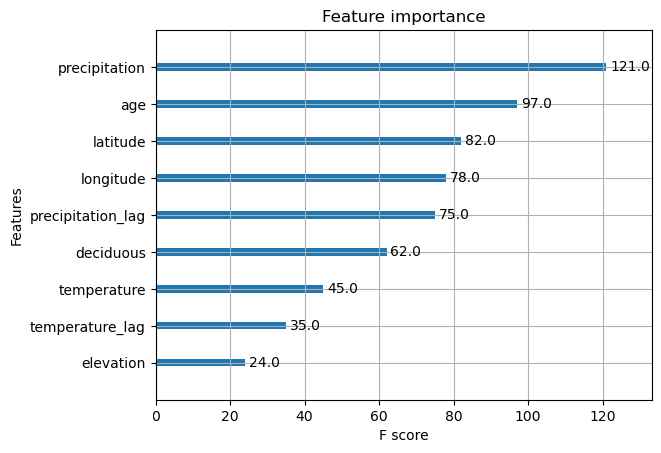

In [181]:
# Plot, metric: weight
#import xgboost as xgb
import matplotlib.pyplot as plt

#xgb.plot_importance(model_m2c, max_num_features=10) # metric=weight is the default
#plt.show()

xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', 
                    xlabel='F score', ylabel='Features', 
                    importance_type='weight', max_num_features=10, grid=True, show_values=True)

#plt.savefig('weight.png',  dpi=300, bbox_inches='tight')

plt.show()

#‘weight’: the number of times a feature is used to split the data across all trees.
# weight: is the percentage representing the relative number of times a particular feature occurs in the trees of the model
# less indicative of the predictive contribution of a feature for the whole model.
# binary feature score low with weight but high with gain and coverage

#‘gain’: the average gain across all splits the feature is used in.
# gain: Gain' is the improvement in accuracy brought by a feature to the branches it is on. Higher value the more important
# The Gain is the most relevant attribute to interpret the relative importance of each feature.
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 

#‘cover’: the average coverage across all splits the feature is used in.
# cover: The Coverage metric means the relative number of observations related to this feature. Observation-level scope

#‘total_gain’: the total gain across all splits the feature is used in.

#‘total_cover’: the total coverage across all splits the feature is used in.




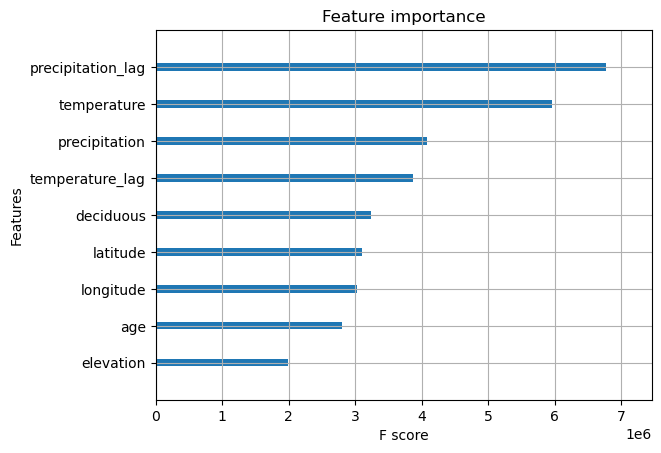

In [182]:
# Plot, metric: gain
xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', 
                    xlabel='F score', ylabel='Features', 
                    importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )

plt.savefig('gain.png',  dpi=300, bbox_inches='tight')


plt.show()

In [96]:
# Alternate way of plotting
# Plot, metric: weight
#feature_importance_weight = model_m2c.get_booster().get_score(importance_type='weight')
#keys = list(feature_importance_weight.keys())
#values = list(feature_importance_weight.values())

#data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
#data.nlargest(40, columns="score").plot(kind='barh', figsize = (10,5)) ## plot top 40 features

#data.head()


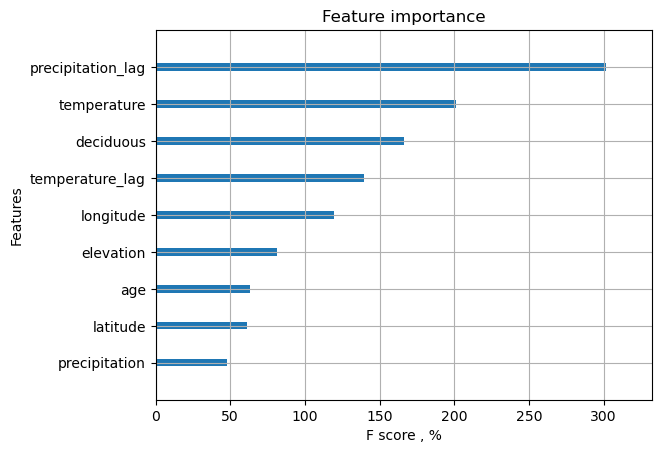

In [183]:
# Plot, metric: cover
xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', 
                    xlabel='F score , %', ylabel='Features', 
                    importance_type='cover', max_num_features=10, grid=True, show_values=False)

plt.show()


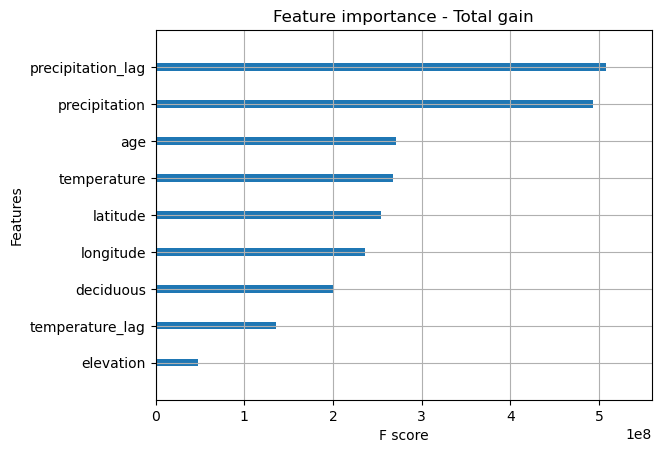

In [184]:
# Plot, metric: total gain
xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance - Total gain', 
                    xlabel='F score', ylabel='Features', 
                    importance_type='total_gain', max_num_features=10, grid=True, show_values=False)

plt.savefig('total_gain.png',  dpi=300, bbox_inches='tight')

plt.show()

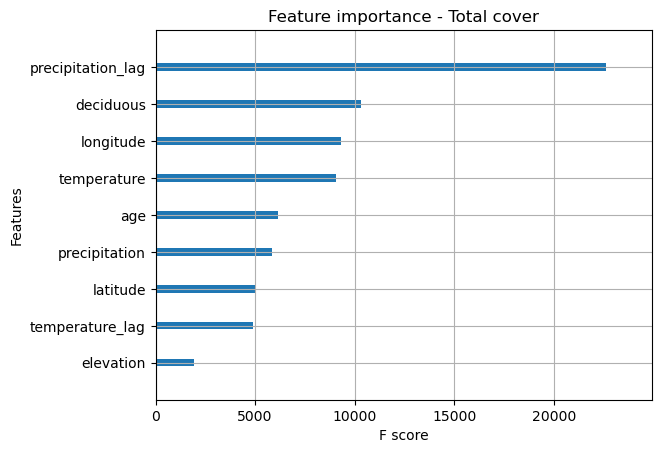

In [185]:
# Plot, metric: total cover
xgb.plot_importance(model_m2e, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance - Total cover', 
                    xlabel='F score', ylabel='Features', 
                    importance_type='total_cover', max_num_features=10, grid=True, show_values=False)

plt.show()

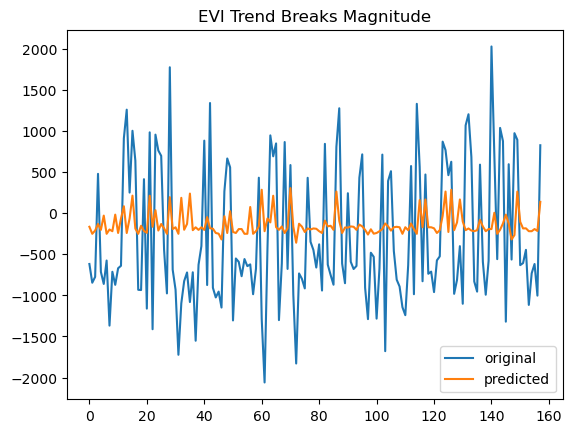

In [186]:
import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
plt.plot(x_ax, y1_test, label="original")
plt.plot(x_ax, ypred, label="predicted")

plt.title("EVI Trend Breaks Magnitude")

plt.legend()

plt.savefig('original_vs_predicted.png',  dpi=300, bbox_inches='tight')

plt.show()

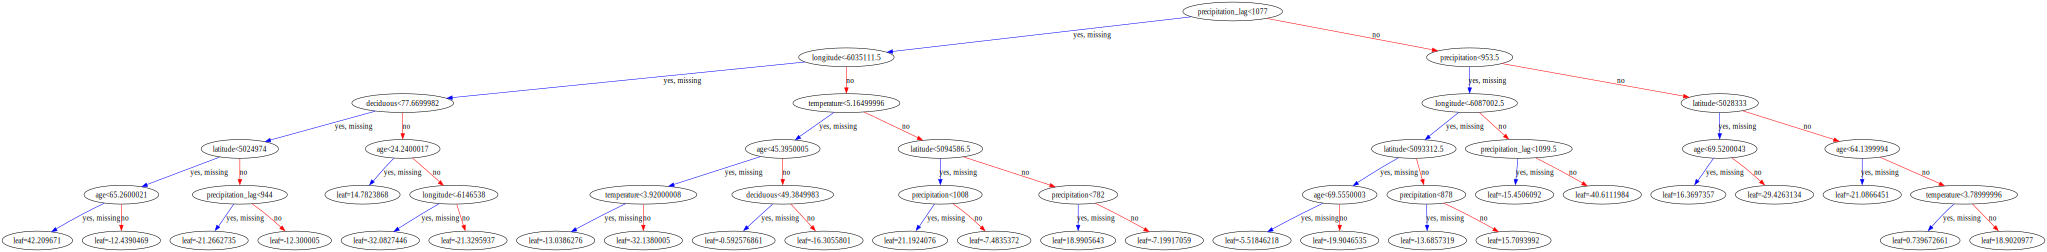

In [187]:
# Plot tree. (Note: package can't be loaded). Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = plt.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))
#xgb.plot_tree(model, num_trees=4)

xgb.to_graphviz(model_m2e, num_trees = 1)


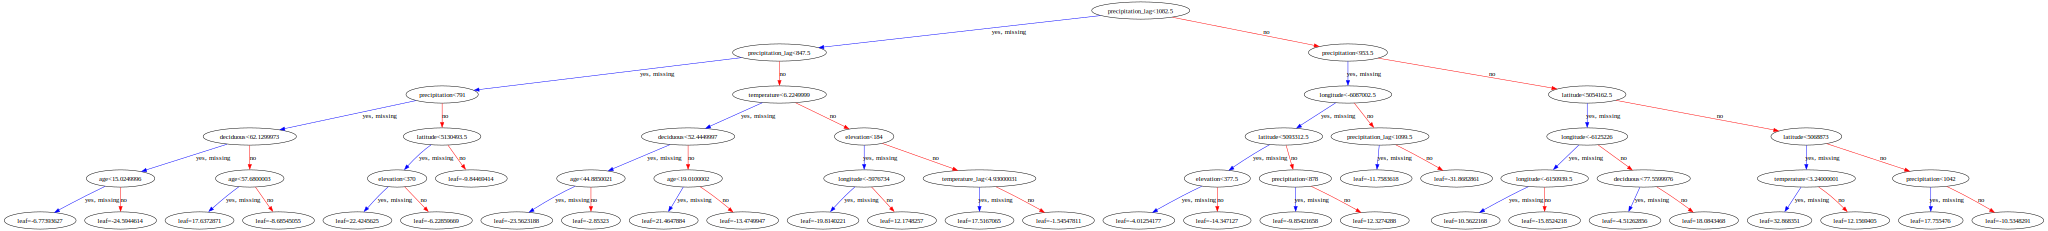

In [188]:
# Plot tree, Best iteration

xgb.to_graphviz(model_m2e, num_trees = model_m2e.best_iteration) #num_trees=xgb_model.best_iteration

#plt.savefig('decision_tree.png',  dpi=300, bbox_inches='tight')

#plt.show()



In [189]:
format = 'png' #You should try the 'svg'

image = xgb.to_graphviz(model_m2e, num_trees = model_m2e.best_iteration)

#Set a different dpi (work only if format == 'png')
image.graph_attr = {'dpi':'300'}

image.render('decision_tree', format = format)


'decision_tree.png'

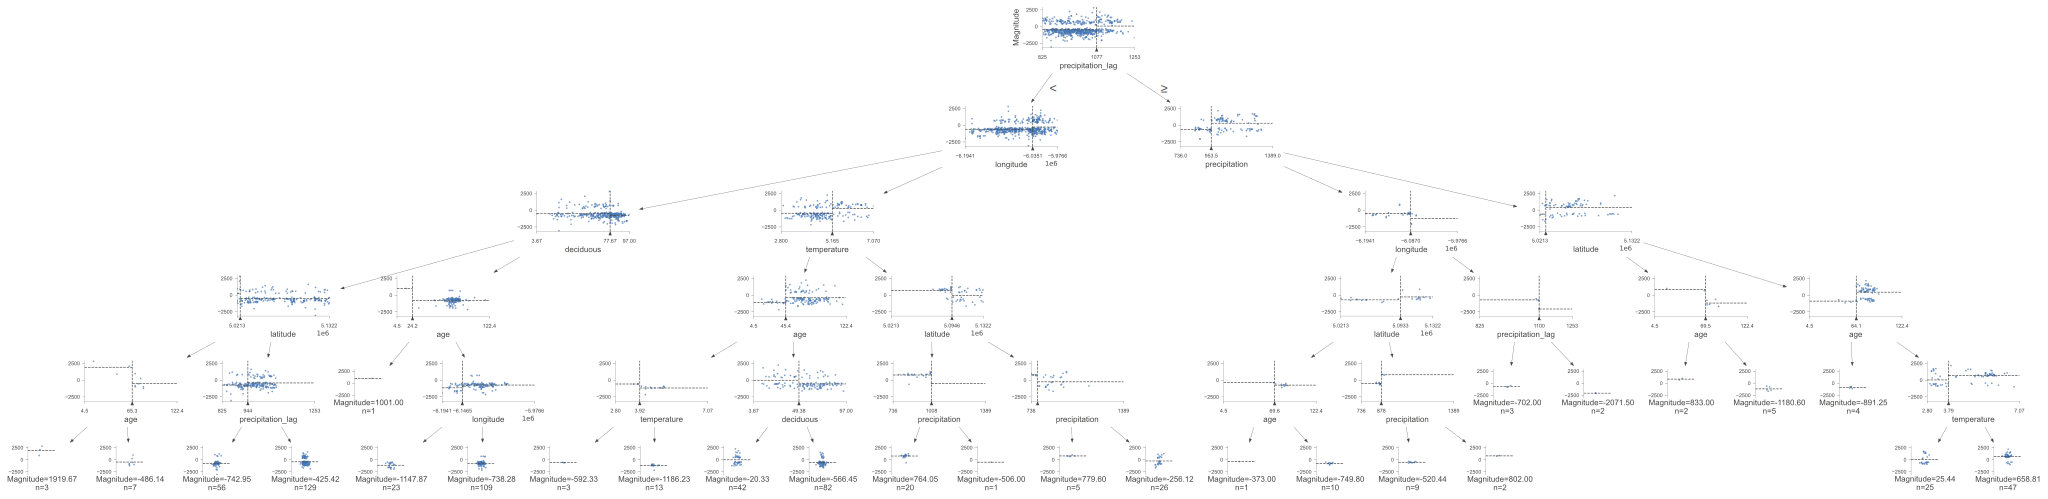

In [190]:
# More plots
from numpy import nan
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

import dtreeviz # To install dtreeviz see: https://github.com/parrt/dtreeviz
import graphviz
import matplotlib.pyplot as plt
#from matplotlib.pylab import rcParams

#import pandas as pd
#import numpy as np

#features_names1 = ["age",  "deciduous" , "conifers" , "elevation", "precipitation" , "temperature", "protected_0",  "driver_class_0" , "driver_class_1" , "driver_class_2"]
#features_names1 = ["fire","harvest","insects","age","deciduous","conifers","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
#features_names1 = ["age","deciduous","conifers","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
target_names1 = "Magnitude"

# tree max is 61 after "stop early"
viz_rmodel = dtreeviz.model(model=model_m2e, tree_index=1, 
                            X_train=x1_train, 
                            y_train=y1_train, 
                            feature_names=features_names1, 
                            target_name=target_names1)

viz_rmodel.view()



In [ ]:
# More plots
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

import dtreeviz # To install dtreeviz see: https://github.com/parrt/dtreeviz
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

#import pandas as pd
#import numpy as np

#features_names1 = ["age","deciduous","conifers","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
features_names1 = ["age","deciduous","elevation","precipitation","temperature","precipitation_lag","temperature_lag","longitude","latitude","protected_0","protected_1"]
target_names1 = "Magnitude"

# tree max is # after "stop early"
viz_rmodel = dtreeviz.model(model=model_m2e, tree_index=model_m2e.best_iteration, 
                            X_train=x1_train, 
                            y_train=y1_train, 
                            feature_names=features_names1, 
                            target_name=target_names1)


viz_rmodel.view()

v = viz_rmodel.view()     # render as SVG into internal object 
#v.show()                 # pop up window
v.save("decision_tree_treeviz.svg")  # optionally save as svg

In [111]:
#import seaborn as sns

#def correlation_heatmap(x1_train):
#    correlations = x1_train.corr()

#    fig, ax = plt.subplots(figsize=(10,10))
#    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
#                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
#                )
#    plt.show();
    
#correlation_heatmap(x1_train[features_names1])
# sorted_idx = xgb.feature_importances_.argsort()


In [18]:
# save in JSON format
#model.save_model("model_regression1.json")
# save in text format
#model_m2.save_model("model_m2.txt")


In [ ]:
# load saved model
#model2 = xgb.Regressor()
#model2.load_model("model_regression1.json")


#### References

Mostly tutorials & blogs.

https://www.youtube.com/watch?v=OQKQHNCVf5k

https://www.youtube.com/watch?v=GrJP9FLV3FE&t=2167s

https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost

https://mljar.com/blog/xgboost-save-load-python/

https://machinelearningmastery.com/xgboost-for-regression/

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

https://github.com/parrt/dtreeviz

https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7



